## Eurofab model training

In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from core.utils import used_keys

from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn import model_selection
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer

In [2]:
v = 'v3'

Read the training data, groups and labels

In [3]:
%%time
X_train = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/training_data4.pq')
y = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/training_labels4.pq')
groups = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/training_hexagons4.pq')

CPU times: user 2min 14s, sys: 1min 58s, total: 4min 12s
Wall time: 36 s


In [4]:
X_train.shape

(42428296, 288)

Map the labels to the appropriate aggregation level

In [5]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

# level_cut = cluster_mapping[3].astype(str)
# level_cut[level_cut == '2'] = '8'


# # assign outliers to the industrial cluster
level_cut = cluster_mapping[4].astype(str)
level_cut[level_cut == '3'] = '15'
level_cut[level_cut == '4'] = '15'
level_cut[level_cut == '10'] = '15'

In [6]:
has_building = ~y.index.str.split('_').str[-1].str.startswith('-')

X_train = X_train[has_building]
y = y[has_building]

assert y.final_without_noise.isna().sum() == 0
assert (y.final_without_noise == -1).sum() == 0
assert (X_train.index == y.index).all()

y.shape

(42401155, 1)

In [7]:
%%time
y['final_without_noise'] = y['final_without_noise'].map(level_cut.to_dict())
y['final_without_noise'].value_counts()

CPU times: user 1.07 s, sys: 136 ms, total: 1.21 s
Wall time: 1.21 s


final_without_noise
13    6813289
8     6295811
6     5301297
14    5300532
7     4771033
5     3735265
1     3539360
9     2681766
12    1947367
11     684150
15     621822
16     547780
2      161683
Name: count, dtype: int64

Undersample and Predict only building classification, so drop empty ETCs.

In [8]:
#sample class size, based on the smallest class
# sample_size = y['final_without_noise'].value_counts()[-1] - 1000


# sample class size fixed value
sample_size = 200_000


sample_size

200000

In [9]:
%%time

np.random.seed(123)
train_indices = []
classes = y.final_without_noise.unique()
has_building = ~y.index.str.split('_').str[-1].str.startswith('-')

# prague_only = y.index.str.startswith('65806')

for cluster in classes:
    random_indices = np.random.choice(np.where((y.final_without_noise == cluster) & (has_building))[0], sample_size, replace=False, )
    train_indices.append(random_indices)

train_indices = np.concat(train_indices)

CPU times: user 36.6 s, sys: 1.81 s, total: 38.4 s
Wall time: 38.4 s


In [10]:
# array([12239990,  1465214, 19863794, ..., 37780729, 36737940, 39044928])
train_indices

array([42027531,  1719710,  4010671, ..., 28697031, 30891194, 26758311])

In [11]:
# # limit to prague only
# X_train = X_train[X_train.index.str.startswith('65806')]
# y = y[y.index.str.startswith('65806')]
# groups = groups[groups.index.str.startswith('65806')]

In [12]:
X_train = X_train.iloc[train_indices]
y = y.iloc[train_indices]
groups = groups.iloc[train_indices]

assert y.final_without_noise.isna().sum() == 0

In [13]:
X_resampled, y_resampled = X_train, y

In [8]:
%%time

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y.final_without_noise)

CPU times: user 1min 14s, sys: 1.18 s, total: 1min 16s
Wall time: 1min 16s


In [9]:
X_resampled.shape

(2101879, 288)

In [7]:
# %%time

# # random sample

# np.random.seed(123)
# train_indices = np.random.choice(np.arange(len(X_train)), size=20_000_000, replace=False)
# X_train, y = X_train.iloc[train_indices], y.iloc[train_indices].final_without_noise

# X_resampled, y_resampled = X_train, y

# train_indices

CPU times: user 33.7 s, sys: 1.18 s, total: 34.9 s
Wall time: 34.8 s


array([41275768, 26335779,  1263004, ...,   147368, 31353073, 28249475])

#### Kfold

Setup kfold splitter based on spatial contiguity

In [8]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    X_train.values,
    y.final_without_noise.values,
    groups=groups.hexagons.values,
)
scoring = {"Balanced Accuracy": make_scorer(balanced_accuracy_score), "Accuracy": make_scorer(accuracy_score)}


In [9]:
factorize_y = y.final_without_noise.factorize()

Setup grid search and evaluation pipeline

In [10]:
# calibrated_forest = CalibratedClassifierCV(
#    estimator=RandomForestClassifier(random_state=123, n_jobs=-1))

# param_grid = {
#     'estimator__max_depth': [2, 4, 6, 8, 20],
#     # 'estimator__max_depth': [2, 4, 6],
#     'estimator__min_samples_split': [2, 50, 100, 200, 400]
#     # 'estimator__min_samples_split': [200, 400]
# }


# search = GridSearchCV(calibrated_forest, param_grid, cv=splits, scoring=scoring, refit="Accuracy", return_train_score=True)

# search.fit(
#     X_train.values,
#     factorize_y[0]
# )

In [12]:
import xgboost

In [12]:
%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(nthread=1, learning_rate=0.02, n_estimators=600,)
search = GridSearchCV(
    xgb_model,
    {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        },
    verbose=1,
    n_jobs=-5,
    cv=splits,
    scoring=scoring,
    refit="Accuracy",
    return_train_score=True
)

search.fit(
    X_train.values,
    factorize_y[0]
)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
CPU times: user 3h 25s, sys: 1h 4min 10s, total: 4h 4min 36s
Wall time: 16d 20h 23min 5s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7abecaac6680>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'Balanced Accuracy': make_scorer(balanced_accuracy_score, response_method='predict')},
             verbose=1)

Select the best model and predict the test data

In [13]:
best_model = search.best_estimator_

In [14]:
import pickle
pickle.dump(best_model, open("best_clasif.pkl", "wb"))

In [13]:
%%time
from xgboost import XGBClassifier

factorize_y = y.final_without_noise.factorize()
# best_model = XGBClassifier(nthread=-1)
best_model = XGBClassifier(nthread=-1, learning_rate=0.02, n_estimators=600, colsample_bytree=1.0,  gamma=0.5, max_depth=5, min_child_weight=1)

best_model.fit(X_train.values, factorize_y[0])

CPU times: user 2h 57min 16s, sys: 4.86 s, total: 2h 57min 21s
Wall time: 7min 30s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

In [53]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

factorize_y = y.final_without_noise.factorize()
# best_model = XGBClassifier(nthread=-1)
# best_model = XGBClassifier(nthread=-1, learning_rate=0.02, n_estimators=600, colsample_bytree=1.0,  gamma=0.5, max_depth=5, min_child_weight=1)


best_model = HistGradientBoostingClassifier()
best_model.fit(X_train.values, y)

/home/krasen/morphometrics/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 32min 25s, sys: 673 ms, total: 32min 26s
Wall time: 3min 1s


HistGradientBoostingClassifier()

#### Random Forest

In [11]:
# to_keep = ['ldsAre_15', 'mibERI_15', 'sicCAR_median', 'ldsMSL_15',
#        'ssbERI_15', 'ssbCCM_85', 'sdsSPO_15', 'linWID_85',
#        'sdsSPO_median', 'ldsRea_15', 'sdcLAL_median', 'likWBB_85',
#        'mdcAre_85', 'mdcAre_median', 'mibAre_85', 'mibLAL_85',
#        'mibSCo_85', 'mibFR_85', 'ldsAre_median', 'lcdMes_median',
#        'ldsRea_median', 'ldsMSL_median', 'ldbPWL_85', 'sdcAre_median',
#        'mibLAL_median', 'likWBB_median', 'mibLen_85', 'lddNDe_85',
#        'ldsMSL', 'mtbNDi_median', 'linPDE_median', 'mibElo_15',
#        'mtcWNe_median', 'linWID', 'ssbCCD_85', 'linWID_median',
#        'sdbPer_85', 'ldsRea', 'sdbAre_85', 'lcdMes_85',
#        'sicCAR_15', 'sddAre_median', 'ldsRea_85']

In [10]:
to_keep = X_train.columns.values

In [11]:
# to_keep = X_train.columns[~X_train.columns.str.contains('_')].values
# to_keep.shape

In [12]:
## validate assignments

# rid = '65806'

# res_index = X_resampled.index[X_resampled.index.str.startswith(str(rid))]
# res_index = res_index.str.split('_').str[-1].astype(int)

# res_label = pd.read_parquet(f'/data/uscuni-eurofab/processed_data/target_clusters/{rid}_target.pq').set_index('index').final_without_noise
# res_label = res_label.loc[res_index]


# res_geom = gpd.read_parquet(f'/data/uscuni-eurofab/processed_data/buildings/buildings_{rid}.parquet')
# res_geom = res_geom.loc[res_index]
# res_geom.loc[res_index, 'label'] = res_label

# res_geom['label'] = res_geom['label'].astype(int).map(level_cut.to_dict())
# res_geom.explore(column='label', categorical=True, tiles='cartodb positron')

In [13]:
%%time
from sklearn.ensemble import RandomForestClassifier

best_model =  RandomForestClassifier(random_state=123, n_jobs=-1, 
                                     oob_score=True,
                                     n_estimators=50, max_samples=200_000, max_features=.5, min_samples_leaf=5, )

best_model.fit(X_resampled[to_keep], y_resampled)

CPU times: user 44min 53s, sys: 9.53 s, total: 45min 2s
Wall time: 3min 10s


RandomForestClassifier(max_features=0.5, max_samples=200000, min_samples_leaf=5,
                       n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=123)

In [14]:
best_model.oob_score_, best_model.score(X_resampled[to_keep], y_resampled)

(0.6050162735342995, 0.6608096850484733)

In [15]:
# from imblearn.ensemble import BalancedRandomForestClassifier

# brf = BalancedRandomForestClassifier(
#     n_estimators=100, max_samples=200_000, max_features=.5, min_samples_leaf=5,
#     n_jobs=-1,
#     sampling_strategy="all",
#     replacement=True,
#     bootstrap=False,
#     random_state=0,
#     verbose=1,
# )

# brf.fit(X_train[to_keep], y.final_without_noise)

# best_model = brf

In [16]:
X_test = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/testing_data4.pq')
y_test = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/testing_labels4.pq')

# # # limit to vienna only
# X_test = X_test[X_test.index.str.startswith('84986')]
# y_test = y_test[y_test.index.str.startswith('84986')]

y_test['final_without_noise'] = y_test['final_without_noise'].map(level_cut.to_dict())

In [17]:

# accuracy_score(best_model.oob_score, y.final_without_noise)

In [18]:
has_building_test = ~y_test.index.str.split('_').str[-1].str.startswith('-')

X_test = X_test[has_building_test]
y_test = y_test[has_building_test]

assert y_test.final_without_noise.isna().sum() == 0
assert (X_test.index == y_test.index).all()

y_test.shape

(2846671, 1)

In [19]:
# factorize y_test using the same factorization scheme for y_train

In [20]:
%%time
predictions = best_model.predict(X_test[to_keep])

CPU times: user 37.8 s, sys: 8.77 s, total: 46.6 s
Wall time: 3.93 s


In [21]:
mapped_predictions = predictions


## use the y_train factorisation scheme to map back the predictions to the original labels
# mapped_predictions = factorize_y[1][predictions]

In [22]:
cluster_4_names = {'1': 'Dense Connected Developments',
 '2': 'Large Interconnected Blocks',
 '3': 'Extensive Courtyard Complexes',
 '4': 'Massive Connected Aggregations',
 '5': 'Dense Standalone Buildings',
 '6': 'Compact Development',
 '7': 'Cul-de-Sac Layout',
 '8': 'Aligned Winding Streets',
 '9': 'Sparse Rural Development',
 '10': 'Large Wide-Spaced Complexes',
 '11': 'Dispersed Linear Development',
 '12': 'Linear Development',
 '13': 'Sparse Open Layout',
 '14': 'Sparse Road-Linked Development',
 '15': 'Large Utilitarian Development',
 '16': 'Extensive Wide-Spaced Developments'}

In [23]:
# cluster_3_names = {
# '1': 'Central Urban Developments',

#  '3': 'Dense Urban Developments',
    
#  '4': 'Street-aligned Developments',
    
#  '5': 'Sparse Rural Development',
    
#  '6': 'Linear Road Network Developments',
    
#  '7': 'Sparse Road Network Developments',
    
#  '8': 'Large Scale Developments'

# }

In [24]:
# majority class
(y_test.final_without_noise.value_counts() / y_test.shape[0]).max()

np.float64(0.4635916830571569)

In [25]:
## vienna accuracy is a good predictor of overall austrian accuracy
accuracy_score(mapped_predictions, y_test)

0.4010375628233821

In [26]:
y_test.value_counts()

final_without_noise
13                     1319693
5                       358010
7                       344269
8                       245229
14                      177507
1                       138700
9                       132152
15                       43833
6                        33877
2                        21143
16                       20298
12                       11528
11                         432
Name: count, dtype: int64

In [27]:
pd.Series(mapped_predictions).value_counts()

13    594425
8     423616
14    377315
7     367997
5     233550
9     202469
6     172436
1     143592
15    118635
2      97309
16     87200
12     25522
11      2605
Name: count, dtype: int64

In [28]:
f1_score(y_test, mapped_predictions, average='weighted'), f1_score(y_test, mapped_predictions, average='micro'), f1_score(y_test, mapped_predictions, average='macro')

(np.float64(0.44309748751826333),
 np.float64(0.4010375628233821),
 np.float64(0.2915534268241278))

In [29]:
f1s_vals = f1_score(y_test, mapped_predictions, average=None)

f1s = pd.Series(
    f1s_vals,
    index = [cluster_4_names[k] for k in sorted(np.unique(mapped_predictions))]
)
f1s

Dense Connected Developments          0.293044
Dispersed Linear Development          0.069147
Linear Development                    0.146127
Sparse Open Layout                    0.512451
Sparse Road-Linked Development        0.176687
Large Utilitarian Development         0.300625
Extensive Wide-Spaced Developments    0.162850
Large Interconnected Blocks           0.259278
Dense Standalone Buildings            0.539817
Compact Development                   0.086306
Cul-de-Sac Layout                     0.462139
Aligned Winding Streets               0.272353
Sparse Rural Development              0.509370
dtype: float64

In [30]:
f1s.mean()

np.float64(0.2915534268241278)

In [31]:
f1s.sort_values()

Dispersed Linear Development          0.069147
Compact Development                   0.086306
Linear Development                    0.146127
Extensive Wide-Spaced Developments    0.162850
Sparse Road-Linked Development        0.176687
Large Interconnected Blocks           0.259278
Aligned Winding Streets               0.272353
Dense Connected Developments          0.293044
Large Utilitarian Development         0.300625
Cul-de-Sac Layout                     0.462139
Sparse Rural Development              0.509370
Sparse Open Layout                    0.512451
Dense Standalone Buildings            0.539817
dtype: float64

In [32]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(best_model, X_train[to_keep])
fi[:20]

,cols,imp
144,ldsAre_15,0.040940
90,ssbERI_15,0.029266
138,ldsMSL_15,0.022876
154,sdsSPO_median,0.022412
226,sicCAR_median,0.019557
153,sdsSPO_15,0.018993
273,mibERI_15,0.017169
98,ssbCCM_85,0.016920
182,linWID_85,0.016726
205,sdcLAL_median,0.016604


In [33]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

39

In [34]:
to_keep.values

array(['ldsAre_15', 'ssbERI_15', 'ldsMSL_15', 'sdsSPO_median',
       'sicCAR_median', 'sdsSPO_15', 'mibERI_15', 'ssbCCM_85',
       'linWID_85', 'sdcLAL_median', 'likWBB_85', 'ldsRea_15',
       'mdcAre_85', 'mibAre_85', 'mibFR_85', 'mibSCo_85', 'mdcAre_median',
       'mibLAL_85', 'ldsAre_median', 'ldsRea_median', 'lcdMes_median',
       'ldbPWL_85', 'mibLAL_median', 'ldsMSL_median', 'likWBB_median',
       'sdbPer_85', 'lddNDe_85', 'mibLen_85', 'likWCe_median',
       'sdcAre_median', 'linPDE_median', 'mtbNDi_median', 'ldsMSL',
       'ssbCCD_85', 'ldsRea', 'mibElo_15', 'ssbSqu_85', 'sicCAR_85',
       'linWID'], dtype=object)

In [33]:
# check leakeage

# %%time

# df_dom = pd.concat([X_train[to_keep], X_test[to_keep]])
# is_valid = np.array([0]*len(X_train[to_keep]) + [1]*len(X_test[to_keep]))

# m = RandomForestClassifier(random_state=123, n_jobs=-1, 
#                                      oob_score=True,
#                                      n_estimators=100, max_samples=200_000, max_features=0.5, min_samples_leaf=25)
# m.fit(df_dom, is_valid)

# rf_feat_importance(m, df_dom)[:6]

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [35]:
cm = confusion_matrix(y_test, mapped_predictions, )

In [36]:
## testing sklearn categorical ordering
cm_vals = cm.sum(axis=0)
pd.testing.assert_series_equal(pd.Series(cm_vals, index = sorted(np.unique(mapped_predictions))).sort_values(ascending=False), pd.Series(mapped_predictions).value_counts(), check_names=False)

cm_vals = cm.sum(axis=1)
pd.testing.assert_series_equal(pd.Series(cm_vals, index = sorted(np.unique(mapped_predictions))).sort_values(ascending=False), y_test.final_without_noise.value_counts(), check_names=False)


In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=[cluster_4_names[k] for k in sorted(np.unique(mapped_predictions))]
                             )

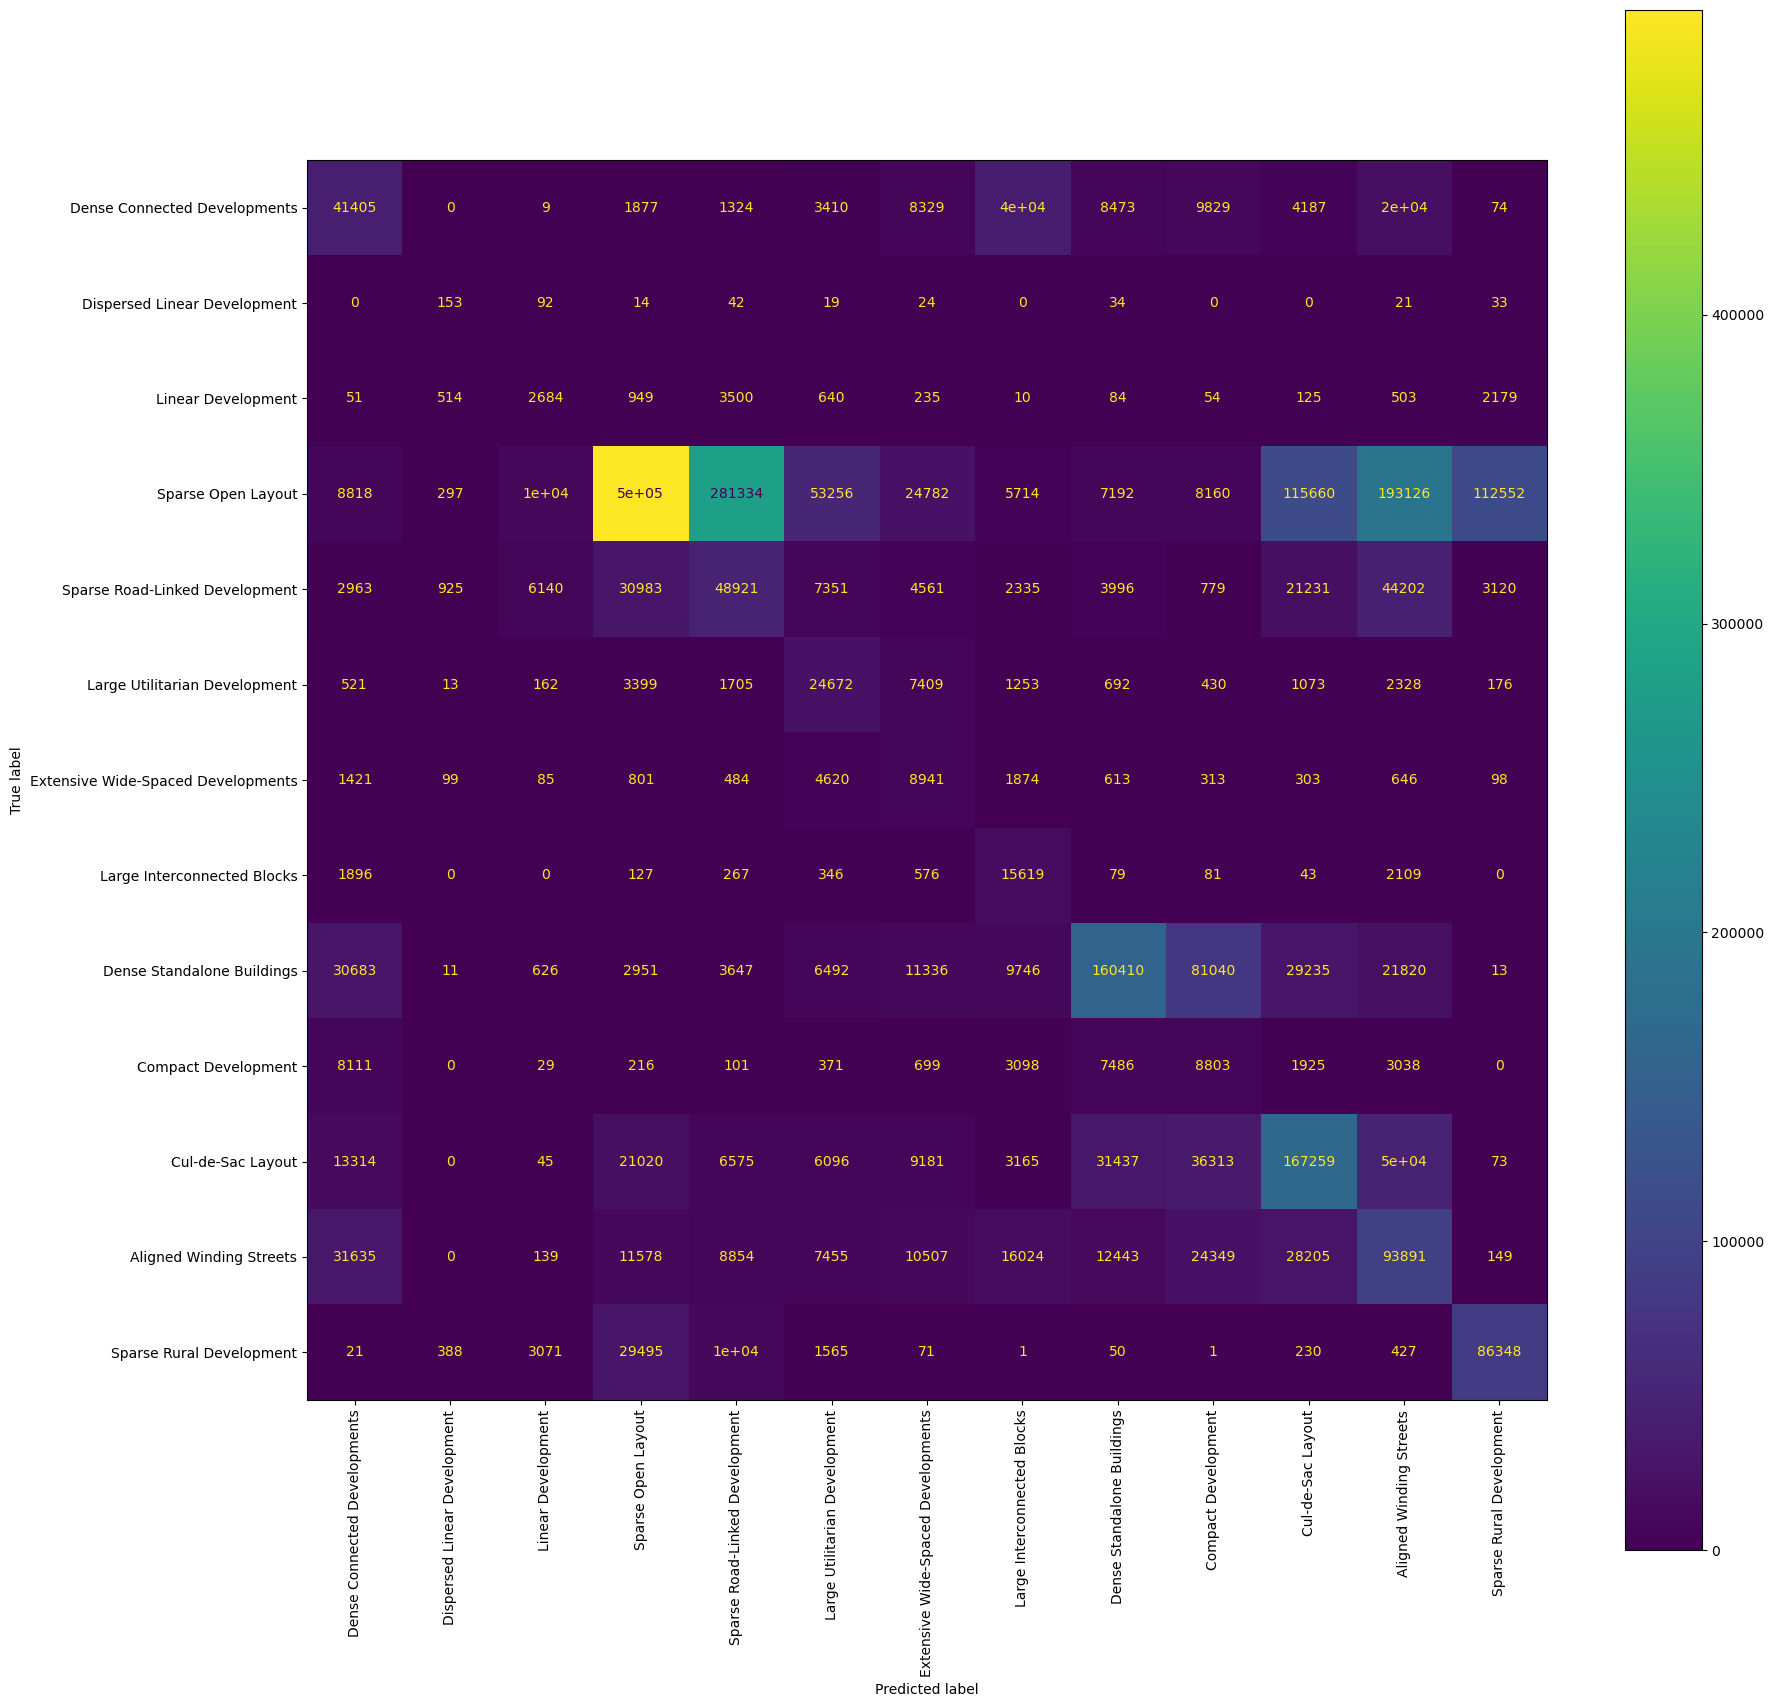

In [38]:
fig,ax = plt.subplots(figsize=(20,20))
disp.plot( xticks_rotation = 'vertical', ax=ax)

### Plot predictions

In [41]:
from lonboard import SolidPolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12
from core.cluster_validation import get_color

In [76]:
# regions_datadir = "/data/uscuni-eurofab/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "ms_ce_region_hulls.parquet"
#     )
# region_hulls.explore()

In [124]:
region_id = 84986  # vienna
# region_id = 61799 # lindz

In [125]:
buildings = gpd.read_parquet(f'/data/uscuni-eurofab/processed_data/buildings/buildings_{region_id}.parquet')

In [126]:
region_vals = y_test.index.str.startswith(str(region_id))
labels = y_test[region_vals].final_without_noise
labels.index = labels.index.str.split('_').str[-1].astype(int)

In [127]:
buildings["predicted_label"] = pd.Series(mapped_predictions[region_vals], labels.index.values)
buildings["true_label"] = labels
# drop buildings that are in the ms data, but not in the cadastre
buildings = buildings.dropna()

In [128]:
# buildings = buildings[buildings.predicted_label != buildings.true_label]

In [129]:
layer = SolidPolygonLayer.from_geopandas(
    gdf=buildings[["geometry", "predicted_label", 'true_label']], get_fill_color=get_color(buildings['true_label'].values.astype(int)), opacity=0.15
)

/home/krasen/morphometrics/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [130]:
m = Map(layer, basemap_style=CartoBasemap.DarkMatter)

In [131]:
from sidecar import Sidecar
sc = Sidecar(title='buildings')
with sc:
    display(m)

In [132]:
final_colors = get_color(np.arange(0, 20))

In [134]:
layer.get_fill_color = final_colors[buildings['predicted_label'].astype(int)]